### Overview
In this notebook we aim to create real world volatility data.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import csv
import requests
import pandas as pd
import scipy
import time
import os

### Getting Our Data
First we define our function to get data from AlphaVantage. The data is minute by minute intraday stock price information. 

In [3]:
API_KEY = "A2IUEA0TKKGILTDY"

def get_intraday_data(symbol=None, interval="1min", time_slice="year1month1"):

    # check if we have already retrieved the requested data
    csv_path = f"./alpha_vantage_data/{symbol}_{interval}_{time_slice}.csv"
    if os.path.isfile(csv_path):
        # if so just load from the csv
        df = pd.read_csv(csv_path)
    else:
        # if not we query the API for the particular slice of data
        CSV_URL = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={symbol}&interval={interval}&slice={time_slice}&apikey={API_KEY}"
        df = pd.read_csv(CSV_URL)
        print(len(df))
        df.to_csv(csv_path)
        # we slepe for 13 seconds to prevent rate limits from being hit
        # (5 requests per minute)
        time.sleep(13)
    print(len(df))
    return df

### Generating volatility for IBM data
We are now going to generate volatility data for IBM using the intraday trading data over the previous year.

In [119]:
# lets get 1 year of data
IBM_data = pd.concat([get_intraday_data(symbol="AAPL", time_slice=f"year1month{m}") for m in range(1,13)])
#IBM_data = pd.concat([IBM_data] + [get_intraday_data(symbol="IBM", time_slice=f"year2month{m}") for m in range(1,13)])

# convert the time column to date time objects
IBM_data['time'] = pd.to_datetime(IBM_data['time'])

16550
15132
15570
16665
16207
15714
16043
18401
17335
15565
16704
17059


Lets plot the prices over time to see if our data looks ok.

249


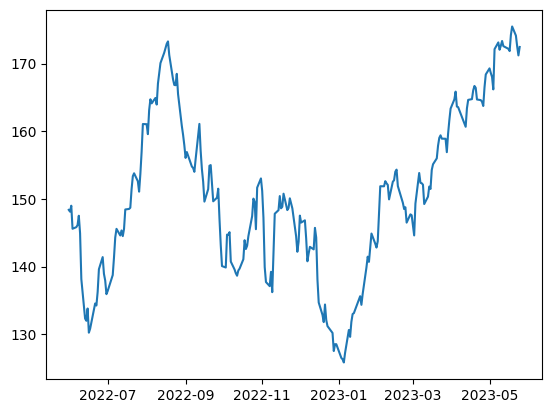

In [120]:
# vol = IBM_data['open'].to_numpy()
# dates = list(IBM_data.index.values)
# plt.plot(dates, vol)


daily_mean_open = IBM_data.groupby([IBM_data['time'].dt.date]).agg(
    mean_open=('open', 'mean'),
)
daily_mean_open = daily_mean_open.sort_index()

dates = list(daily_mean_open.index.values)

print(len(daily_mean_open))

plt.plot(dates, daily_mean_open['mean_open'].to_numpy())

We now perform the following steps to transform this data
1. Take the log of all the price movements
2. Calculate the differences between subsequent log price movements
3. Square these differences
4. Add all the the squared differences for each day
5. Divide each sum by the number of squared differences and then take the square root to get the volatility

In [127]:
# IBM_data['time'] = pd.to_datetime(IBM_data['time'])
IBM_data = IBM_data.sort_values('time')
IBM_data = IBM_data.reset_index(drop=True)
IBM_data['log_open'] = np.log(IBM_data['open'])
IBM_data['log_returns'] = IBM_data["log_open"] - (IBM_data["log_open"][0])
IBM_data['log_returns_sq'] = IBM_data['log_returns'] ** 2
IBM_daily_vol = IBM_data.groupby([IBM_data["time"].dt.date]).agg(  # can also use pd.Grouper(key="time",freq='1D')
    sum_value=('log_returns_sq', 'sum'),
    count_value=('log_returns_sq', 'count')
)
IBM_daily_vol['volatility'] = np.sqrt(IBM_daily_vol['sum_value']/IBM_daily_vol['count_value'])
IBM_daily_vol = IBM_daily_vol.sort_values('time')

Lets plot the volatility and see what it looks like

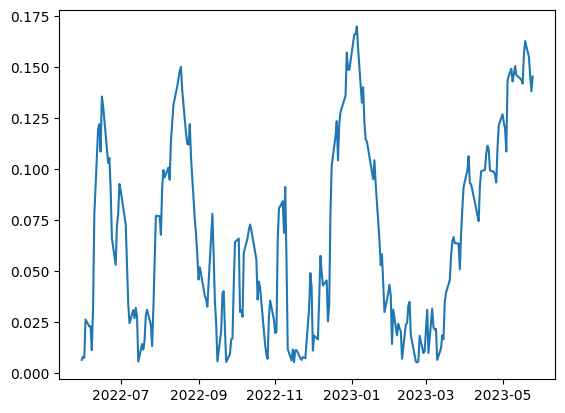

In [128]:
vol=IBM_daily_vol['volatility'].to_numpy()
dates = list(IBM_daily_vol.index.values)
plt.plot(dates[0:400], vol[0:400])

And now lets save our volatility dataframe as a CSV file

In [135]:
volatility_csv_path = f"./volatility_data/AAPL_daily_vol.csv"
IBM_daily_vol.to_csv(volatility_csv_path)

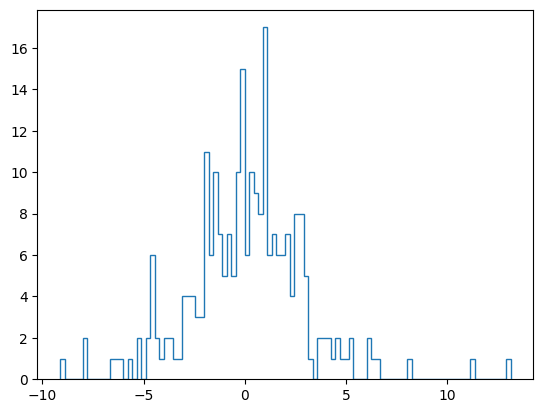

In [107]:
vol_change = daily_data['open'].diff().to_numpy()
vol_change = vol_change[~np.isnan(vol_change)]
counts, bins = np.histogram(vol_change, bins=100)
plt.stairs(counts, bins)

### Saving Additional Data
We need to save some additional datasets like daily prices.

In [144]:
# lets get 1 year of data
IBM_data.sort_values('time', ascending=True)
daily_data = IBM_data.groupby([IBM_data["time"].dt.date]).last()
daily_data["log_open"] = np.log(daily_data["open"])
daily_data["log_returns"] = daily_data["log_open"].diff()
daily_data["log_returns"] = daily_data["log_open"] - daily_data["log_open"][0]
daily_data["volatility"] = np.abs(daily_data["log_returns"])

Lets plot it to check that it looks correct. We'll also plot the daily volatility we calculated earlier from hf data in red as a sanity check.

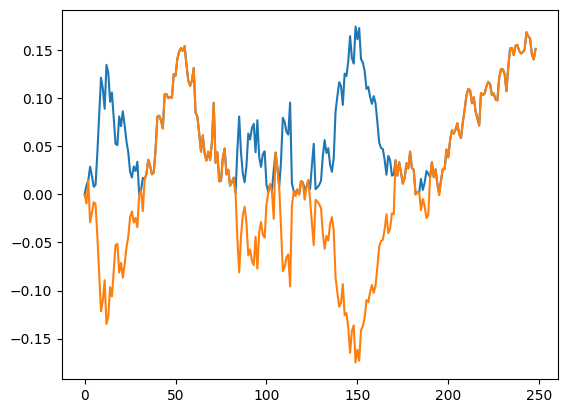

In [147]:
plt.plot(daily_data["volatility"].to_numpy())
#plt.plot(vol, c='r', linewidth=0.4)

plt.plot(daily_data["log_returns"].to_numpy())

Ok lets save this data

In [146]:
daily_data.to_csv("./price_data/AAPL_daily_price_data")